In [19]:
import numpy as np

def zcomplex(r, theta):
    return 0.5 + r * np.exp(1j * (np.pi - theta))

# First sampling
def sample_z1(num_samples=20):
    z_samples = []
    for _ in range(num_samples):
        r = (2 / 10) * np.sqrt(np.random.uniform(0, 1))
        theta = np.random.uniform(0, (7 * np.pi / 40))
        z = zcomplex(r, theta)
        z_samples.append(z)
    return z_samples

# Second sampling
def sample_z2(num_samples=20):
    z_samples = []
    for _ in range(num_samples):
        r = np.sqrt(
            np.random.uniform(0, 1) * (((35 / 100) ** 2) - ((3 / 10) ** 2)) + ((3 / 10) ** 2)
        )
        theta = np.random.uniform(1, (np.pi / 2))
        z = zcomplex(r, theta)
        z_samples.append(z)
    return z_samples

# Combine samples
z_samples = np.array(sample_z1() + sample_z2())


In [5]:
from mpmath import mp, mpc, sqrt, exp, pi, conj, hyper

# Set precision (number of decimal places)
mp.dps = 25


In [1]:
def compute_equation(z, C2, C3, d2, d3):
    # Convert z to mpmath complex number
    z_mp = mpc(z)
    z_conj = conj(z_mp)
    
    # Compute absolute values and powers
    abs_1_minus_z = abs(1 - z_mp)
    abs_z = abs(z_mp)
    
    term1 = 1 / abs_1_minus_z ** (4 / 5)
    term2 = 1 / abs_z ** (4 / 5)
    
    # Compute hypergeometric terms
    def hypergeo(a, b, c, x):
        return hyper([a, b], [c], x)
    
    # First big term involving 3.65312
    hg1 = hypergeo(-1/5, -1/5, -2/5, 1 - z_mp)
    hg1_conj = hypergeo(-1/5, -1/5, -2/5, 1 - z_conj)
    hg2 = hypergeo(-1/5, -1/5, -2/5, z_mp)
    hg2_conj = hypergeo(-1/5, -1/5, -2/5, z_conj)
    
    big_term1_numerator = - (hg1 * hg1_conj) / ((1 - z_mp) ** (1/5) * abs_z ** (4/5) * (1 - z_conj) ** (1/5))
    big_term1_denominator = (hg2 * hg2_conj) / (z_mp ** (1/5) * abs_1_minus_z ** (4/5) * z_conj ** (1/5))
    big_term1 = -3.65312 * (big_term1_numerator + big_term1_denominator)
    
    # Second term involving C2 and d2
    # Implement the terms similar to the above, using the expressions in your equation
    # For brevity, let's define a function to compute these terms
    
    def compute_C_term(C, d, z_mp, z_conj):
        # Compute hypergeometric functions for this term
        hg1 = hypergeo(0.5 * (-2 + d), 0.5 * (-2 + d), -2 + d, 1 - z_conj)
        hg2 = hypergeo(0.5 * (2 + d), 0.5 * (2 + d), 2 + d, 1 - z_mp)
        hg3 = hypergeo(0.5 * (-2 + d), 0.5 * (-2 + d), -2 + d, 1 - z_mp)
        hg4 = hypergeo(0.5 * (2 + d), 0.5 * (2 + d), 2 + d, 1 - z_conj)
        
        hg5 = hypergeo(0.5 * (-2 + d), 0.5 * (-2 + d), -2 + d, z_conj)
        hg6 = hypergeo(0.5 * (2 + d), 0.5 * (2 + d), 2 + d, z_mp)
        hg7 = hypergeo(0.5 * (-2 + d), 0.5 * (-2 + d), -2 + d, z_mp)
        hg8 = hypergeo(0.5 * (2 + d), 0.5 * (2 + d), 2 + d, z_conj)
        
        term_a = ((1 - z_mp) ** ((2 + d) / 2) * (1 - z_conj) ** ((-2 + d) / 2) * hg1 * hg2)
        term_b = ((1 - z_mp) ** ((-2 + d) / 2) * (1 - z_conj) ** ((2 + d) / 2) * hg3 * hg4)
        
        term_c = (z_mp ** ((2 + d) / 2) * z_conj ** ((-2 + d) / 2) * hg5 * hg6)
        term_d = (z_mp ** ((-2 + d) / 2) * z_conj ** ((2 + d) / 2) * hg7 * hg8)
        
        result = - (1 / abs_z ** (4 / 5)) * (term_a + term_b) + (1 / abs_1_minus_z ** (4 / 5)) * (term_c + term_d)
        return C * result
    
    # Compute terms involving C2 and C3
    term_C2 = compute_C_term(C2, d2, z_mp, z_conj)
    term_C3 = compute_C_term(C3, d3, z_mp, z_conj)
    
    # Total equation
    equation = term1 - term2 + big_term1 + term_C2 + term_C3
    
    return equation


In [ ]:
import gym
from gym import spaces
import numpy as np
from mpmath import mp, mpc, sqrt, exp, pi, hyper, mpf
import itertools

class StandardDeviationEnv(gym.Env):
    """
    Custom Environment for solving the crossing equation involving hypergeometric functions.
    """
    metadata = {'render.modes': ['human']}

    def __init__(
        self,
        min_d2: float = 0.1,
        max_d2: float = 5.0,
        min_d3: float = 0.1,
        max_d3: float = 5.0,
        d_lr: float = 0.1,
        max_episode_steps: int = 50,
        num_samples: int = 20,  # Number of (z1, z2) pairs
    ):
        super(StandardDeviationEnv, self).__init__()

        # Set precision for mpmath
        mp.dps = 25

        # Parameters
        self.min_d2 = min_d2
        self.max_d2 = max_d2
        self.min_d3 = min_d3
        self.max_d3 = max_d3
        self.d_lr = d_lr  # Learning rate for d2 and d3 updates
        self.max_episode_steps = max_episode_steps
        self.num_samples = num_samples  # Number of (z1, z2) pairs

        # Initialize variables
        self.reward = 0.0
        self.std_over_mean_sum = None

        # Initialize d2 and d3
        self.d2 = 1.0
        self.d3 = 2.0

        # Action and observation spaces
        # Actions: d2_step, d3_step
        action_low = np.array([-1.0, -1.0], dtype=np.float32)
        action_high = np.array([1.0, 1.0], dtype=np.float32)

        # Observations: d2, d3, mean_C2, mean_C3, std_over_mean_sum
        obs_low = np.array(
            [self.min_d2, self.min_d3, -np.inf, -np.inf, 0.0],
            dtype=np.float32
        )
        obs_high = np.array(
            [self.max_d2, self.max_d3, np.inf, np.inf, np.inf],
            dtype=np.float32
        )

        self.action_space = spaces.Box(low=action_low, high=action_high, dtype=np.float32)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        # Count steps
        self.num_steps = 0

        # Fixed parameters (set these to your actual values)
        self.Delta_sigma = mpf('-0.4')  # Δσ
        self.Delta1 = mpf('-0.4')       # Δ[1]
        self.s1 = mpf('0')              # Spin for operator 1
        self.C1 = mpf('-3.65312')       # Coefficient C[1]
        self.s2 = mpf('2')              # Spin for operator 2
        self.s3 = mpf('4')              # Spin for operator 3

        # Initialize state variables
        self.reset()

    # Sampling functions
    def zcomplex(self, r, theta):
        return mpf('0.5') + r * mp.exp(1j * (mp.pi - theta))

    def sample_z1(self):
        r = mpf('0.2') * sqrt(mp.rand())
        theta = mp.rand() * (mpf('7') * mp.pi / mpf('40'))
        z = self.zcomplex(r, theta)
        return z

    def sample_z2(self):
        r_squared = mp.rand() * (((mpf('35') / mpf('100')) ** 2) - ((mpf('3') / mpf('10')) ** 2)) + ((mpf('3') / mpf('10')) ** 2)
        r = sqrt(r_squared)
        theta = mpf('1') + mp.rand() * (mp.pi / mpf('2') - mpf('1'))
        z = self.zcomplex(r, theta)
        return z

    def kronecker_delta(self, h, hb, tol=1e-8):
        return mpf('1.0') if abs(h - hb) < tol else mpf('0.0')

    def g(self, h, hb, z):
        delta = self.kronecker_delta(h, hb)
        denominator = delta + mpf('1.0')

        # Compute hypergeometric functions
        hg_h_z = hyper([h, h], [2 * h], z)
        hg_hb_z_conj = hyper([hb, hb], [2 * hb], z.conjugate())
        hg_h_z_conj = hyper([h, h], [2 * h], z.conjugate())
        hg_hb_z = hyper([hb, hb], [2 * hb], z)

        # Compute terms
        term1 = z ** h * z.conjugate() ** hb * hg_h_z * hg_hb_z_conj
        term2 = z.conjugate() ** h * z ** hb * hg_h_z_conj * hg_hb_z

        # Combine terms
        result = (term1 + term2) / denominator
        return result
    
    

    def compute_equation(self, z, d2, d3):
        try:
            # Fixed parameters
            Delta_sigma = self.Delta_sigma
            Delta1 = self.Delta1
            s1 = self.s1
            C1 = self.C1
            s2 = self.s2
            s3 = self.s3
            Delta2 = mpf(d2)
            Delta3 = mpf(d3)

            # h and hb for each operator
            h1 = (Delta1 + s1) / 2
            hb1 = (Delta1 - s1) / 2

            h2 = (Delta2 + s2) / 2
            hb2 = (Delta2 - s2) / 2

            h3 = (Delta3 + s3) / 2
            hb3 = (Delta3 - s3) / 2

            # z and z_conj
            z_mp = mpc(z)
            z_conj = z_mp.conjugate()

            # Precompute factors
            abs_z_minus_1_2Delta_sigma = abs(1 - z_mp) ** (2 * Delta_sigma)
            abs_z_2Delta_sigma = abs(z_mp) ** (2 * Delta_sigma)

            # Compute g functions
            g1_z = self.g(h1, hb1, z_mp)
            g1_1_minus_z = self.g(h1, hb1, 1 - z_mp)
            g2_z = self.g(h2, hb2, z_mp)
            g2_1_minus_z = self.g(h2, hb2, 1 - z_mp)
            g3_z = self.g(h3, hb3, z_mp)
            g3_1_minus_z = self.g(h3, hb3, 1 - z_mp)

            # Compute the crossing equation
            term1 = C1 * (abs_z_minus_1_2Delta_sigma * g1_z - abs_z_2Delta_sigma * g1_1_minus_z)
            term2 = (abs_z_minus_1_2Delta_sigma * g2_z - abs_z_2Delta_sigma * g2_1_minus_z)
            term3 = (abs_z_minus_1_2Delta_sigma * g3_z - abs_z_2Delta_sigma * g3_1_minus_z)
            term_identity = abs_z_minus_1_2Delta_sigma - abs_z_2Delta_sigma

            # The total equation should be zero
            # equation = term1 + C2 * term2 + C3 * term3 + term_identity = 0

            # Rearranged to solve for C2 and C3
            # equation = D - A * C2 - B * C3

            D = - (term1 + term_identity)
            A = term2
            B = term3

            return (A, B, D)
        except Exception as e:
            print(f"Error in compute_equation for z={z}: {e}")
            return None

    def compute_reward(self, d2, d3):
        cs_list = []  # To collect (C2, C3) estimates

        for _ in range(self.num_samples):
            # Generate a pair of z1 and z2
            z1 = self.sample_z1()
            z2 = self.sample_z2()
            equations = []

            # For each z in [z1, z2]
            for z in [z1, z2]:
                eq = self.compute_equation(z, d2, d3)
                if eq is not None:
                    equations.append(eq)
                else:
                    # If the equation couldn't be computed, skip this sample
                    break  # Skip to the next sample pair

            if len(equations) == 2:
                # Solve equations for this pair
                try:
                    A1, B1, D1 = equations[0]
                    A2, B2, D2 = equations[1]

                    # Form the coefficient matrix and constant vector
                    A_matrix = np.array([[A1.real, B1.real],
                                         [A2.real, B2.real]], dtype=np.float64)
                    D_vector = np.array([D1.real, D2.real], dtype=np.float64)

                    # Solve the linear system
                    sol = np.linalg.solve(A_matrix, D_vector)

                    C2 = sol[0]
                    C3 = sol[1]

                    cs_list.append((C2, C3))
                except Exception as e:
                    # Singular matrix or other numerical issue; skip this sample
                    continue
            else:
                # Not enough equations; skip this sample
                continue

        if len(cs_list) == 0:
            # No valid solutions found; assign a low reward
            self.cs = np.array([0.0, 0.0])
            self.std_over_mean_sum = 1e6
            return -1e6
        else:
            cs_array = np.array(cs_list)
            C2_values = cs_array[:, 0]
            C3_values = cs_array[:, 1]
            C2_mean = np.mean(C2_values)
            C3_mean = np.mean(C3_values)
            C2_std = np.std(C2_values, ddof=1)
            C3_std = np.std(C3_values, ddof=1)
            means = (C2_mean, C3_mean)
            stds = (C2_std, C3_std)

            # Compute reward
            reward = self.get_reward(means, stds)
            self.cs = np.array(means, dtype=np.float32)
            # Compute std_over_mean_sum for observation
            epsilon = 1e-8
            cs_mean_safe = np.where(np.abs(self.cs) < epsilon, epsilon, np.abs(self.cs))
            std_over_mean = np.array(stds) / cs_mean_safe
            self.std_over_mean_sum = np.sum(std_over_mean)
            return reward

    def get_reward(self, means, stds):
        """
        Calculate the reward based on the mean and std of C2 and C3.
        Reward = - (log(abs(std1 / mean1)) + log(abs(std2 / mean2)))
        """
        C2_mean, C3_mean = means
        C2_std, C3_std = stds

        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-8
        denominator1 = np.abs(C2_mean) + epsilon
        denominator2 = np.abs(C3_mean) + epsilon
        ratio1 = np.abs(C2_std) / denominator1
        ratio2 = np.abs(C3_std) / denominator2

        # Clip ratios to avoid log(0)
        min_ratio = 1e-8
        ratio1 = np.clip(ratio1, min_ratio, None)
        ratio2 = np.clip(ratio2, min_ratio, None)

        # Compute the reward
        reward = - (np.log(ratio1) + np.log(ratio2))
        return reward

    def _get_obs(self):
        return np.array(
            [self.d2, self.d3, self.cs[0], self.cs[1], self.std_over_mean_sum],
            dtype=np.float32
        )

    def reset(self):
        self.num_steps = 0

        # Initialize d2 and d3 randomly within bounds
        self.d2 = np.random.uniform(self.min_d2, self.max_d2)
        self.d3 = np.random.uniform(self.min_d3, self.max_d3)

        # Compute initial reward and observation
        self.reward = self.compute_reward(self.d2, self.d3)

        observation = self._get_obs()
        return observation

    def step(self, action):
        self.num_steps += 1

        # Update d2 and d3
        d2 = self.d2 + self.d_lr * action[0]
        d3 = self.d3 + self.d_lr * action[1]

        # Check boundary conditions
        is_ok = self.d_bc(d2, d3)

        done = False

        if not is_ok:
            # Penalize the agent for invalid values
            self.reward = -10.0
            done = True
            observation = self._get_obs()
            return observation, self.reward, done, {}

        # Updat


In [18]:
import gym
from gym import spaces
import numpy as np
from scipy.special import hyp2f1
import cmath

class StandardDeviationEnv(gym.Env):
    """
    Custom Environment for solving the crossing equation involving hypergeometric functions,
    using scipy.special.hyp2f1 for better performance and an improved reward structure.
    """
    metadata = {'render.modes': ['human']}

    def __init__(
        self,
        min_d2: float = 1.0,
        max_d2: float = 3.0,
        min_d3: float = 3.0,
        max_d3: float = 4.0,
        d_lr: float = 0.1,
        max_episode_steps: int = 50,
        num_samples: int = 20,  # Number of (z1, z2) pairs
        impr_coeff: float = 10.0,  # Coefficient for improvement term
    ):
        super(StandardDeviationEnv, self).__init__()

        # Parameters
        self.min_d2 = min_d2
        self.max_d2 = max_d2
        self.min_d3 = min_d3
        self.max_d3 = max_d3
        self.d_lr = d_lr  # Learning rate for d2 and d3 updates
        self.max_episode_steps = max_episode_steps
        self.num_samples = num_samples  # Number of (z1, z2) pairs
        self.impr_coeff = impr_coeff  # Improvement coefficient

        # Initialize variables
        self.reward = 0.0
        self.prev_reward = None  # Initialize previous reward
        self.std_over_mean_sum = None

        # Initialize d2 and d3
        self.d2 = 1.0
        self.d3 = 2.0

        # Action and observation spaces
        # Actions: d2_step, d3_step
        action_low = np.array([-1.0, -1.0], dtype=np.float32)
        action_high = np.array([1.0, 1.0], dtype=np.float32)

        # Observations: d2, d3, mean_C2, mean_C3, std_over_mean_sum
        obs_low = np.array(
            [self.min_d2, self.min_d3, -np.inf, -np.inf, 0.0],
            dtype=np.float32
        )
        obs_high = np.array(
            [self.max_d2, self.max_d3, np.inf, np.inf, np.inf],
            dtype=np.float32
        )

        self.action_space = spaces.Box(low=action_low, high=action_high, dtype=np.float32)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        # Count steps
        self.num_steps = 0

        # Fixed parameters (set these to your actual values)
        self.Delta_sigma = -0.4  # Δσ
        self.Delta1 = -0.4       # Δ[1]
        self.s1 = 0.0            # Spin for operator 1
        self.C1 = -3.65312       # Coefficient C[1]
        self.s2 = 2.0            # Spin for operator 2
        self.s3 = 4.0            # Spin for operator 3

        # Initialize state variables
        self.reset()

    # Sampling functions
    def zcomplex(self, r, theta):
        return 0.5 + r * cmath.exp(1j * (cmath.pi - theta))

    def sample_z1(self):
        r = 0.2 * np.sqrt(np.random.rand())
        theta = np.random.rand() * (7 * np.pi / 40)
        z = self.zcomplex(r, theta)
        return z

    def sample_z2(self):
        r_squared = np.random.rand() * (((35 / 100) ** 2) - ((3 / 10) ** 2)) + ((3 / 10) ** 2)
        r = np.sqrt(r_squared)
        theta = 1 + np.random.rand() * (np.pi / 2 - 1)
        z = self.zcomplex(r, theta)
        return z

    def kronecker_delta(self, h, hb, tol=1e-8):
        return 1.0 if abs(h - hb) < tol else 0.0

    def g(self, h, hb, z):
        delta = self.kronecker_delta(h, hb)
        denominator = delta + 1.0

        # Compute hypergeometric functions using scipy
        z_conj = np.conj(z)

        hg_h_z = hyp2f1(h, h, 2 * h, z)
        hg_hb_z_conj = hyp2f1(hb, hb, 2 * hb, z_conj)
        hg_h_z_conj = hyp2f1(h, h, 2 * h, z_conj)
        hg_hb_z = hyp2f1(hb, hb, 2 * hb, z)

        # Compute terms
        term1 = (z ** h) * (z_conj ** hb) * hg_h_z * hg_hb_z_conj
        term2 = (z_conj ** h) * (z ** hb) * hg_h_z_conj * hg_hb_z

        # Combine terms
        result = (term1 + term2) / denominator
        return result
    

    def compute_equation(self, z, d2, d3):
        try:
            # Fixed parameters
            Delta_sigma = self.Delta_sigma
            Delta1 = self.Delta1
            s1 = self.s1
            C1 = self.C1
            s2 = self.s2
            s3 = self.s3
            Delta2 = d2
            Delta3 = d3

            # h and hb for each operator
            h1 = (Delta1 + s1) / 2
            hb1 = (Delta1 - s1) / 2

            h2 = (Delta2 + s2) / 2
            hb2 = (Delta2 - s2) / 2

            h3 = (Delta3 + s3) / 2
            hb3 = (Delta3 - s3) / 2

            # Ensure h and hb are real numbers
            h1, hb1 = float(h1), float(hb1)
            h2, hb2 = float(h2), float(hb2)
            h3, hb3 = float(h3), float(hb3)

            # z and z_conj
            z = complex(z)
            z_conj = np.conj(z)

            # Precompute factors
            abs_z_minus_1_2Delta_sigma = abs(1 - z) ** (2 * Delta_sigma)
            abs_z_2Delta_sigma = abs(z) ** (2 * Delta_sigma)

            # Compute g functions
            g1_z = self.g(h1, hb1, z)
            g1_1_minus_z = self.g(h1, hb1, 1 - z)
            g2_z = self.g(h2, hb2, z)
            g2_1_minus_z = self.g(h2, hb2, 1 - z)
            g3_z = self.g(h3, hb3, z)
            g3_1_minus_z = self.g(h3, hb3, 1 - z)

            # Compute the crossing equation
            term1 = C1 * (abs_z_minus_1_2Delta_sigma * g1_z - abs_z_2Delta_sigma * g1_1_minus_z)
            term2 = (abs_z_minus_1_2Delta_sigma * g2_z - abs_z_2Delta_sigma * g2_1_minus_z)
            term3 = (abs_z_minus_1_2Delta_sigma * g3_z - abs_z_2Delta_sigma * g3_1_minus_z)
            term_identity = abs_z_minus_1_2Delta_sigma - abs_z_2Delta_sigma

            # The total equation should be zero
            # equation = term1 + C2 * term2 + C3 * term3 + term_identity = 0

            # Rearranged to solve for C2 and C3
            # equation = D - A * C2 - B * C3

            D = - (term1 + term_identity)
            A = term2
            B = term3

            return (A, B, D)
        except Exception as e:
            print(f"Error in compute_equation for z={z}: {e}")
            return None

    def compute_reward(self, d2, d3):
        cs_list = []  # To collect (C2, C3) estimates

        for _ in range(self.num_samples):
            # Generate a pair of z1 and z2
            z1 = self.sample_z1()
            z2 = self.sample_z2()
            equations = []

            # For each z in [z1, z2]
            for z in [z1, z2]:
                eq = self.compute_equation(z, d2, d3)
                if eq is not None:
                    equations.append(eq)
                else:
                    # If the equation couldn't be computed, skip this sample
                    break  # Skip to the next sample pair

            if len(equations) == 2:
                # Solve equations for this pair
                try:
                    A1, B1, D1 = equations[0]
                    A2, B2, D2 = equations[1]

                    # Form the coefficient matrix and constant vector
                    A_matrix = np.array([
                        [A1.real, B1.real],
                        [A2.real, B2.real]
                    ], dtype=np.float64)
                    D_vector = np.array([D1.real, D2.real], dtype=np.float64)

                    # Solve the linear system
                    sol = np.linalg.solve(A_matrix, D_vector)

                    C2 = sol[0]
                    C3 = sol[1]

                    cs_list.append((C2, C3))
                except Exception as e:
                    # Singular matrix or other numerical issue; skip this sample
                    continue
            else:
                # Not enough equations; skip this sample
                continue

        if len(cs_list) == 0:
            # No valid solutions found; assign a low reward
            self.cs = np.array([0.0, 0.0])
            self.std_over_mean_sum = 1e6
            return -1e6
        else:
            cs_array = np.array(cs_list)
            C2_values = cs_array[:, 0]
            C3_values = cs_array[:, 1]
            C2_mean = np.mean(C2_values)
            C3_mean = np.mean(C3_values)
            C2_std = np.std(C2_values, ddof=1)
            C3_std = np.std(C3_values, ddof=1)
            means = (C2_mean, C3_mean)
            stds = (C2_std, C3_std)

            # Compute reward
            reward = self.get_reward(means, stds)
            self.cs = np.array(means, dtype=np.float32)
            # Compute std_over_mean_sum for observation
            epsilon = 1e-8
            cs_mean_safe = np.where(np.abs(self.cs) < epsilon, epsilon, np.abs(self.cs))
            std_over_mean = np.array(stds) / cs_mean_safe
            self.std_over_mean_sum = np.sum(std_over_mean)
            return reward

    def get_reward(self, means, stds):
        """
        Calculate the reward based on the mean and std of C2 and C3.
        Reward = - (log(abs(std1 / mean1)) + log(abs(std2 / mean2)))
        """
        C2_mean, C3_mean = means
        C2_std, C3_std = stds

        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-8
        denominator1 = np.abs(C2_mean) + epsilon
        denominator2 = np.abs(C3_mean) + epsilon
        ratio1 = np.abs(C2_std) / denominator1
        ratio2 = np.abs(C3_std) / denominator2

        # Clip ratios to avoid log(0)
        min_ratio = 1e-8
        ratio1 = np.clip(ratio1, min_ratio, None)
        ratio2 = np.clip(ratio2, min_ratio, None)

        # Compute the reward
        reward = - (np.log(ratio1) + np.log(ratio2))
        return reward

    def _get_obs(self):
        return np.array(
            [self.d2, self.d3, self.cs[0], self.cs[1], self.std_over_mean_sum],
            dtype=np.float32
        )

    def reset(self):
        self.num_steps = 0
        self.prev_reward = None  # Reset previous reward

        # Initialize d2 and d3 randomly within bounds
        self.d2 = np.random.uniform(self.min_d2, self.max_d2)
        self.d3 = np.random.uniform(self.min_d3, self.max_d3)

        # Compute initial reward and observation
        self.reward = self.compute_reward(self.d2, self.d3)

        # Set prev_reward to the initial immediate reward
        self.prev_reward = self.reward

        observation = self._get_obs()
        return observation

    def step(self, action):
        self.num_steps += 1

        # Update d2 and d3
        d2 = self.d2 + self.d_lr * action[0]
        d3 = self.d3 + self.d_lr * action[1]

        # Check boundary conditions
        is_ok = self.d_bc(d2, d3)

        done = False

        if not is_ok:
            # Penalize the agent for invalid values
            self.reward = -10.0
            done = True
            observation = self._get_obs()
            return observation, self.reward, done, {}

        # Update variables
        self.d2 = d2
        self.d3 = d3

        # Compute the immediate reward
        current_reward = self.compute_reward(self.d2, self.d3)

        # Calculate the change in immediate reward
        if self.prev_reward is not None:
            delta_reward = current_reward - self.prev_reward
        else:
            delta_reward = 0.0

        # Compute the total reward
        self.reward = current_reward + self.impr_coeff * delta_reward

        # Update the previous reward
        self.prev_reward = current_reward

        # Check if episode should be truncated due to max steps
        if self.num_steps >= self.max_episode_steps:
            done = True

        # Check for NaNs in observation
        observation = self._get_obs()
        if np.isnan(observation).any():
            self.reward = -10.0
            done = True
            return observation, self.reward, done, {}

        return observation, self.reward, done, {}

    def d_bc(self, d2, d3):
        # Check bounds
        if d2 < self.min_d2 or d2 > self.max_d2:
            return False
        if d3 < self.min_d3 or d3 > self.max_d3:
            return False
        return True

    def render(self, mode='human'):
        """
        Render the environment.
        """
        print(f"Step: {self.num_steps}")
        print(f"d2: {self.d2:.4f}, d3: {self.d3:.4f}")
        print(f"C2_mean: {self.cs[0]:.4f}, C3_mean: {self.cs[1]:.4f}")
        print(f"Std over Mean Sum: {self.std_over_mean_sum:.4f}")
        print(f"Reward: {self.reward:.4f}")
        print("-" * 30)

    def close(self):
        pass


In [ ]:
env.compute_reward(2,3.6)

10.078811797154774

In [16]:
env.cs

array([-0.01787064, -0.00061999], dtype=float32)

In [17]:
env = StandardDeviationEnv()

In [12]:
env = StandardDeviationEnv()
env.reset()
env.d2=1.
env.compute_reward( 1.9, 2.6)

9.094704841492899

In [ ]:
env.compute_reward( env.delta1, env.delta2)

Computing immediate rewards over the delta plane...


  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/n_/wc4mh9w578z14yty8h6vvbph0000gn/T/ipykernel_37853/4068080622.py:112: RuntimeWarning: invalid value encountered in scalar add
  result = (term1 + term2) / denominator
/var/folders/n_/wc4mh9w578z14yty8h6vvbph0000gn/T/ipykernel_37853/4068080622.py:112: RuntimeWarning: invalid value encountered in scalar divide
  result = (term1 + term2) / denominator
100%|██████████| 50/50 [00:10<00:00,  4.80it/s]


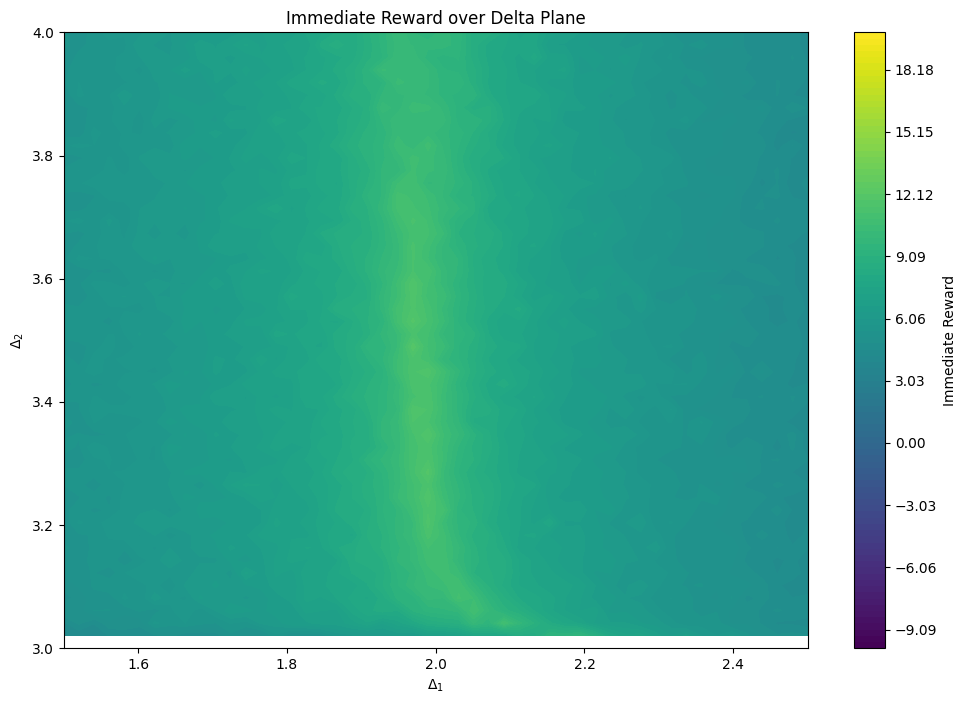

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

# Assuming StandardDeviationEnv is already defined and adjusted
env = StandardDeviationEnv()

# Modify the solve_subsets method to use all combinations


# Now proceed to compute the immediate rewards over the delta plane
delta1_values = np.linspace(1.5, 2.5, 50)
delta2_values = np.linspace(3.0, 4.0, 50)
delta1_grid, delta2_grid = np.meshgrid(delta1_values, delta2_values)
immediate_reward_grid = np.zeros_like(delta1_grid)

epsilon = 1e-8

print("Computing immediate rewards over the delta plane...")
for i in tqdm(range(delta1_grid.shape[0])):
    for j in range(delta1_grid.shape[1]):
        delta1 = delta1_grid[i, j]
        delta2 = delta2_grid[i, j]

        # Set deltas
        env.delta1 = delta1
        env.delta2 = delta2

        # Compute reward
        immediate_reward =env.compute_reward( env.delta1, env.delta2)
      
        immediate_reward_grid[i, j] = immediate_reward

# Apply clipping for visualization
immediate_reward_grid = np.where(immediate_reward_grid < -1e5, -1e5, immediate_reward_grid)

# Plotting
plt.figure(figsize=(12, 8))
contour = plt.contourf(delta1_grid, delta2_grid, immediate_reward_grid, levels=np.linspace(-10, 20, 100), cmap='viridis')
plt.colorbar(contour, label='Immediate Reward')
plt.xlabel(r'$\Delta_1$')
plt.ylabel(r'$\Delta_2$')
plt.title('Immediate Reward over Delta Plane')
plt.show()


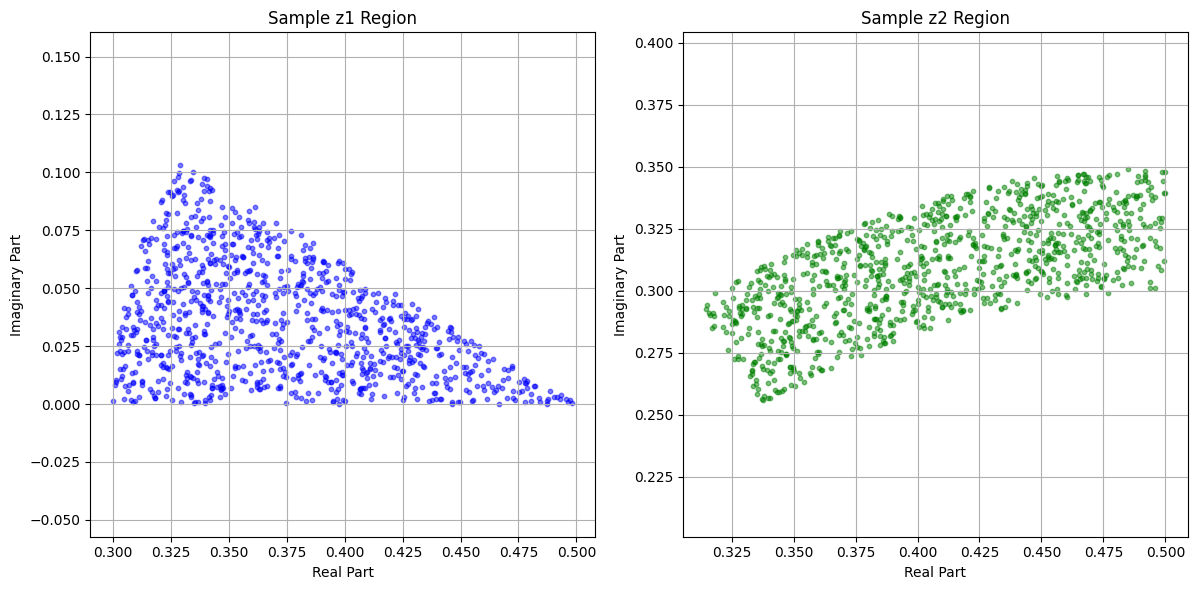

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def zcomplex(r, theta):
    """
    Compute z = 1/2 + r * exp(i * (π - θ))
    """
    return 0.5 + r * np.exp(1j * (np.pi - theta))

def sample_z1(num_samples=1000):
    """
    Generate samples for the first region.
    """
    u = np.random.uniform(0, 1, num_samples)
    r = (2 / 10) * np.sqrt(u)
    theta = np.random.uniform(0, (7 * np.pi / 40), num_samples)
    z = zcomplex(r, theta)
    return z

def sample_z2(num_samples=1000):
    """
    Generate samples for the second region.
    """
    r_min = 3 / 10
    r_max = 35 / 100
    r_squared_min = r_min ** 2
    r_squared_max = r_max ** 2
    u = np.random.uniform(0, 1, num_samples)
    r_squared = u * (r_squared_max - r_squared_min) + r_squared_min
    r = np.sqrt(r_squared)
    theta = np.random.uniform(1, (np.pi / 2), num_samples)
    z = zcomplex(r, theta)
    return z

# Generate samples
num_samples = 1000  # Adjust the number of samples as needed
z_samples1 = sample_z1(num_samples)
z_samples2 = sample_z2(num_samples)

# Extract real and imaginary parts
z1_real = z_samples1.real
z1_imag = z_samples1.imag

z2_real = z_samples2.real
z2_imag = z_samples2.imag

# Plot the samples
plt.figure(figsize=(12, 6))

# Plot sample_z1 points
plt.subplot(1, 2, 1)
plt.scatter(z1_real, z1_imag, color='blue', alpha=0.5, s=10)
plt.title('Sample z1 Region')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')
plt.grid(True)

# Plot sample_z2 points
plt.subplot(1, 2, 2)
plt.scatter(z2_real, z2_imag, color='green', alpha=0.5, s=10)
plt.title('Sample z2 Region')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:

from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt

# Assuming the StandardDeviationEnv class is defined in the same script or imported appropriately

# Initialize the environment
env = StandardDeviationEnv()



# Create the RL model
model = SAC(
    'MlpPolicy',
    env,
    verbose=1,
    tensorboard_log="./sac_standard_deviation_tensorboard/",
    # You can adjust hyperparameters here
    learning_rate=3e-4,
    buffer_size=1000000,
    learning_starts=10000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    ent_coef='auto',
    target_update_interval=1,
)

# Train the agent
# Adjust the total_timesteps based on computational resources
model.learn(total_timesteps=100000)

# Save the trained model
model.save("sac_standard_deviation_cft")

# To load the model later:
# model = PPO.load("ppo_standard_deviation")


In [2]:

from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt

# Assuming the StandardDeviationEnv class is defined in the same script or imported appropriately

# Initialize the environment
env = StandardDeviationEnv()



# Create the RL model
model = SAC(
    'MlpPolicy',
    env,
    verbose=1,
    tensorboard_log="./sac_standard_deviation_tensorboard/",
    # You can adjust hyperparameters here
    learning_rate=3e-4,
    buffer_size=1000000,
    learning_starts=10000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    ent_coef='auto',
    target_update_interval=1,
)



# Save the trained model
model.load("sac_standard_deviation_cft")

# To load the model later:
# model = PPO.load("ppo_standard_deviation")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/homebrew/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [6]:




# Number of evaluation episodes
num_episodes = 10  # You can increase this number to record multiple episodes

# Initialize a list to store trajectories
trajectories = []

for episode in range(num_episodes):
    observation = env.reset()
    done = False
    trajectory = {'delta2': [], 'delta3': [], 'reward': []}
    total_reward = 0.0
    while not done:
        # Record delta1 and delta2 before taking the action
        delta2 = env.d2
        delta3 = env.d3
        trajectory['delta2'].append(delta2)
        trajectory['delta3'].append(delta3)
        
        # Agent selects action
        action, _ = model.predict(observation, deterministic=True)
        
        # Environment steps
        observation, reward, done, info = env.step(action)
        total_reward += reward
        
        # Record reward (optional)
        trajectory['reward'].append(reward)
        
    trajectories.append(trajectory)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")


Episode 1 finished with total reward: 50.467565447378135
Episode 2 finished with total reward: 126.35659627018111
Episode 3 finished with total reward: 250.55217455436258
Episode 4 finished with total reward: -10.0
Episode 5 finished with total reward: 54.541590395729045
Episode 6 finished with total reward: 59.44611028970523
Episode 7 finished with total reward: 161.3931436739984
Episode 8 finished with total reward: -1.4027633618820872
Episode 9 finished with total reward: 148.96845975813727
Episode 10 finished with total reward: 184.2087373677846


In [12]:
env.compute_reward(2,3.6)

10.39725447190418

/var/folders/n_/wc4mh9w578z14yty8h6vvbph0000gn/T/ipykernel_39208/271276352.py:115: RuntimeWarning: invalid value encountered in scalar add
  result = (term1 + term2) / denominator
/var/folders/n_/wc4mh9w578z14yty8h6vvbph0000gn/T/ipykernel_39208/271276352.py:115: RuntimeWarning: invalid value encountered in scalar divide
  result = (term1 + term2) / denominator


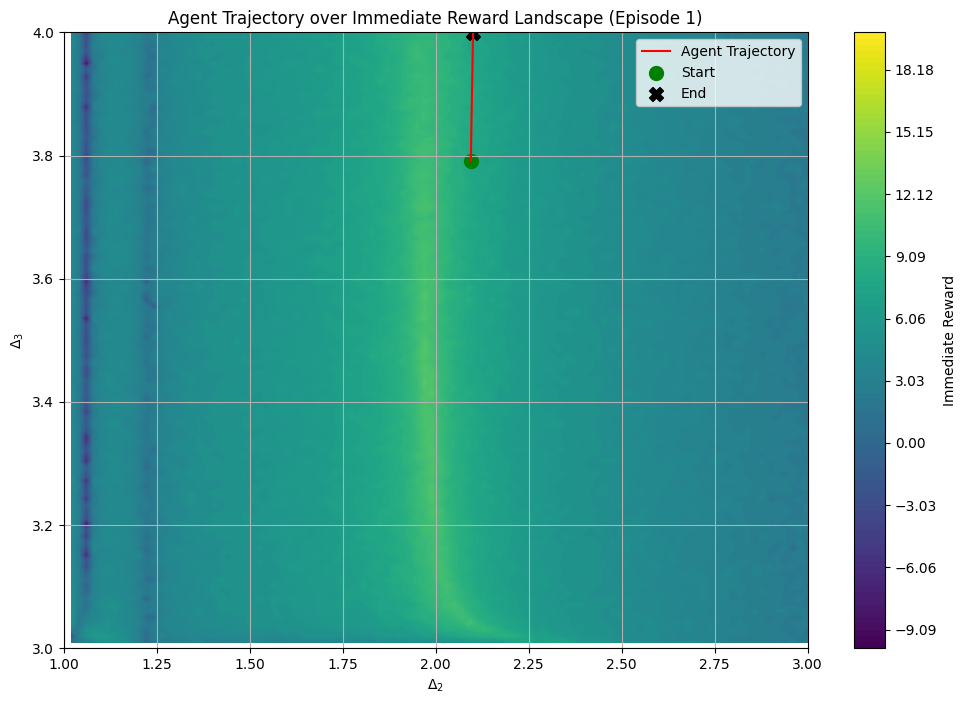

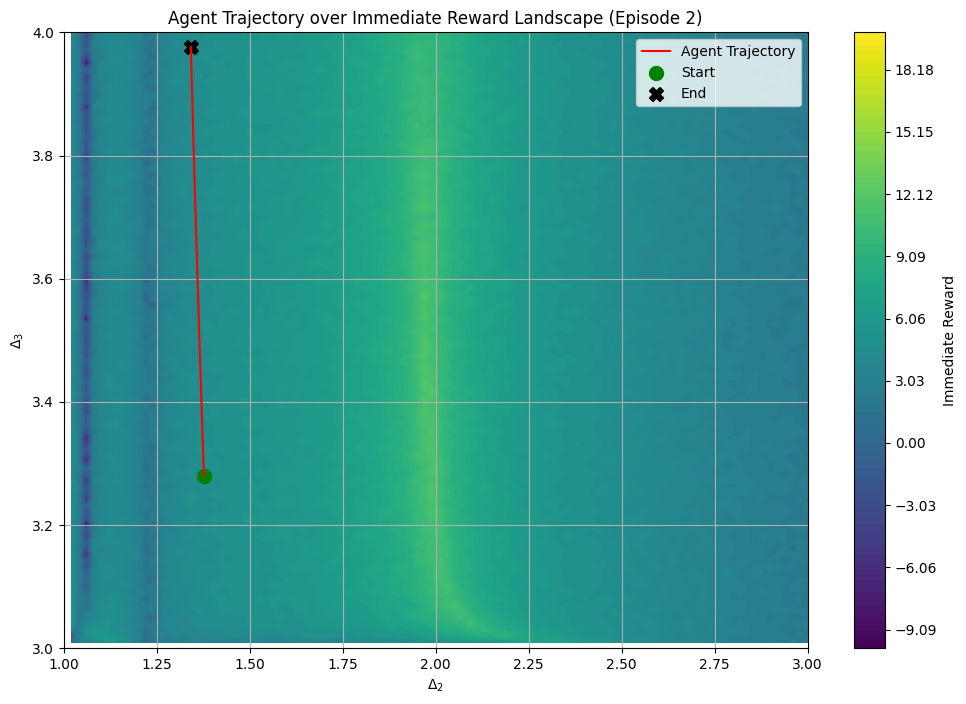

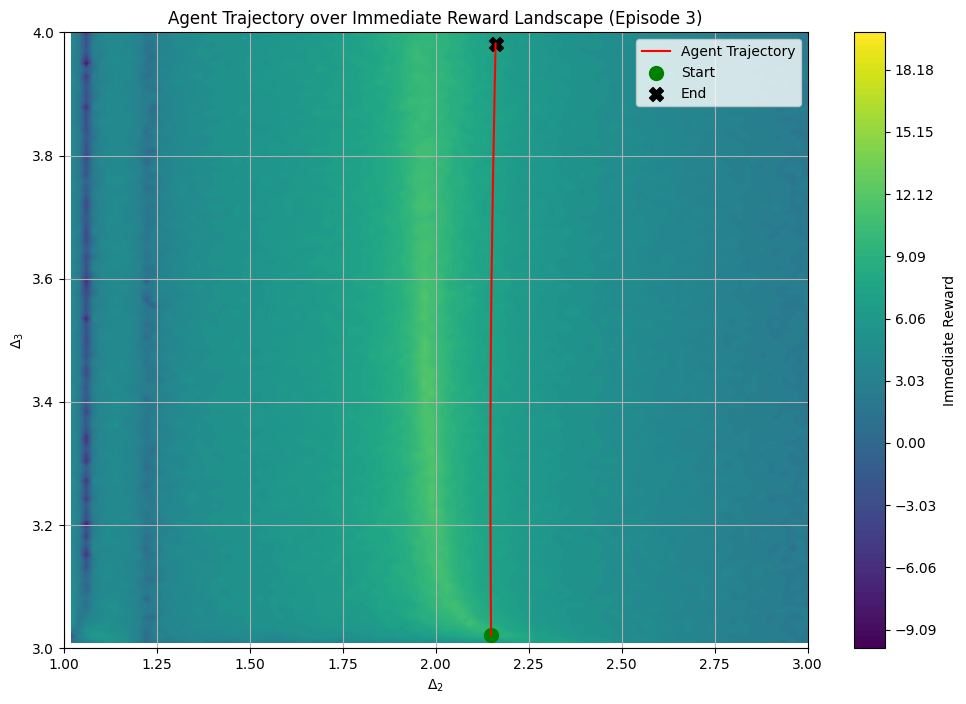

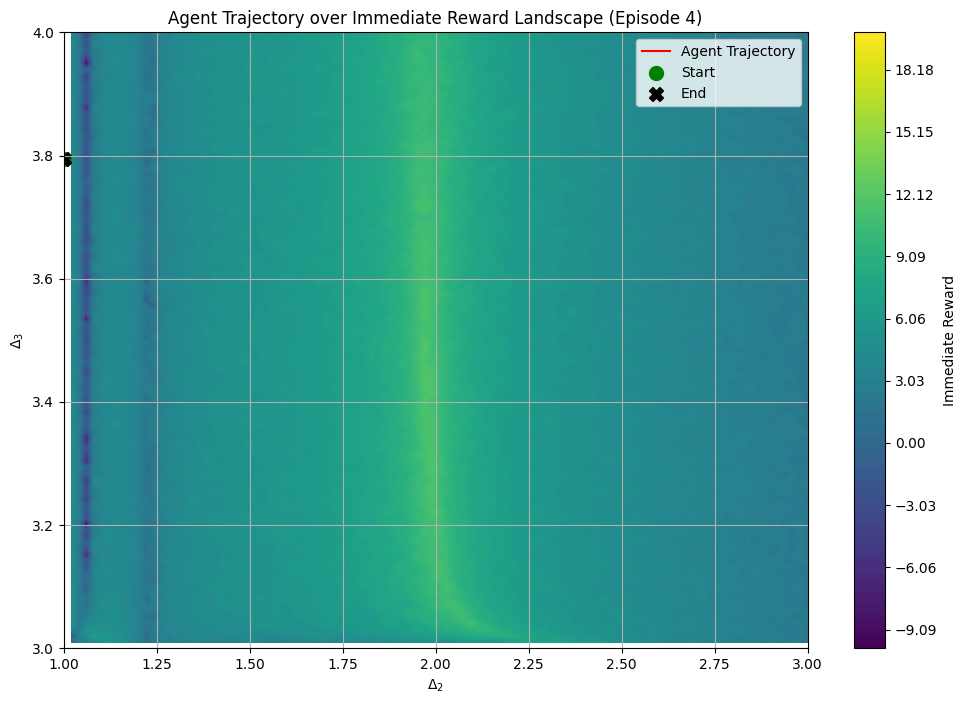

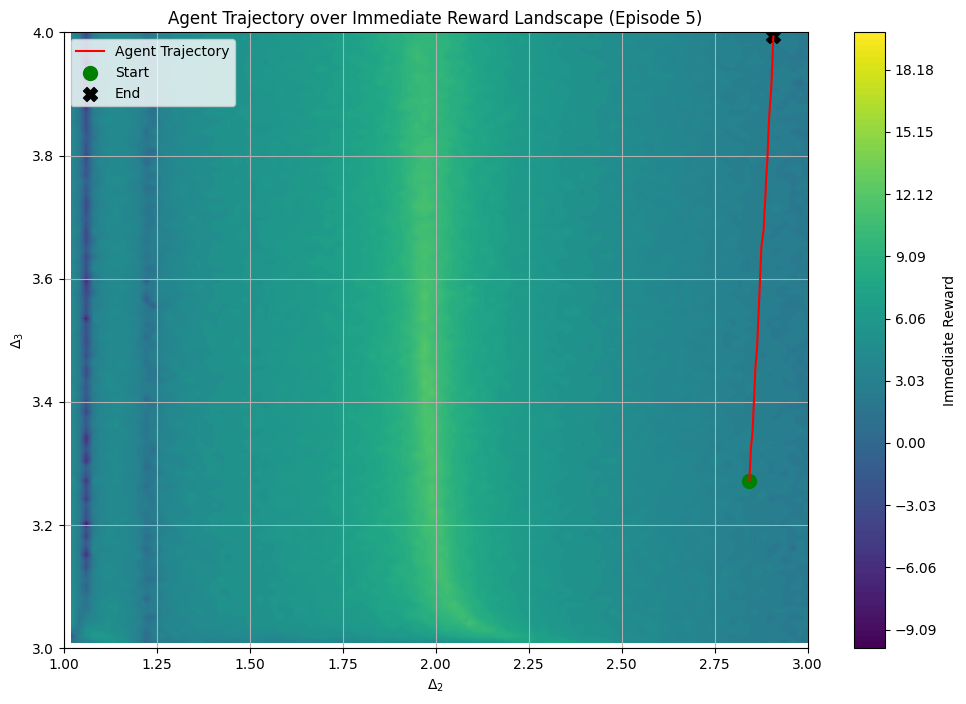

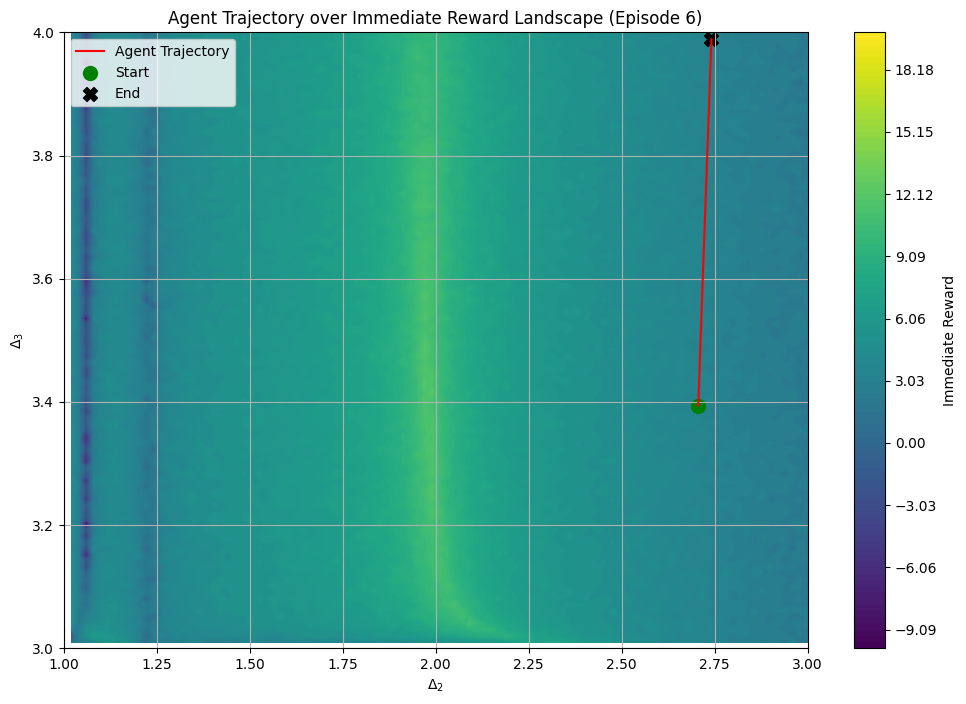

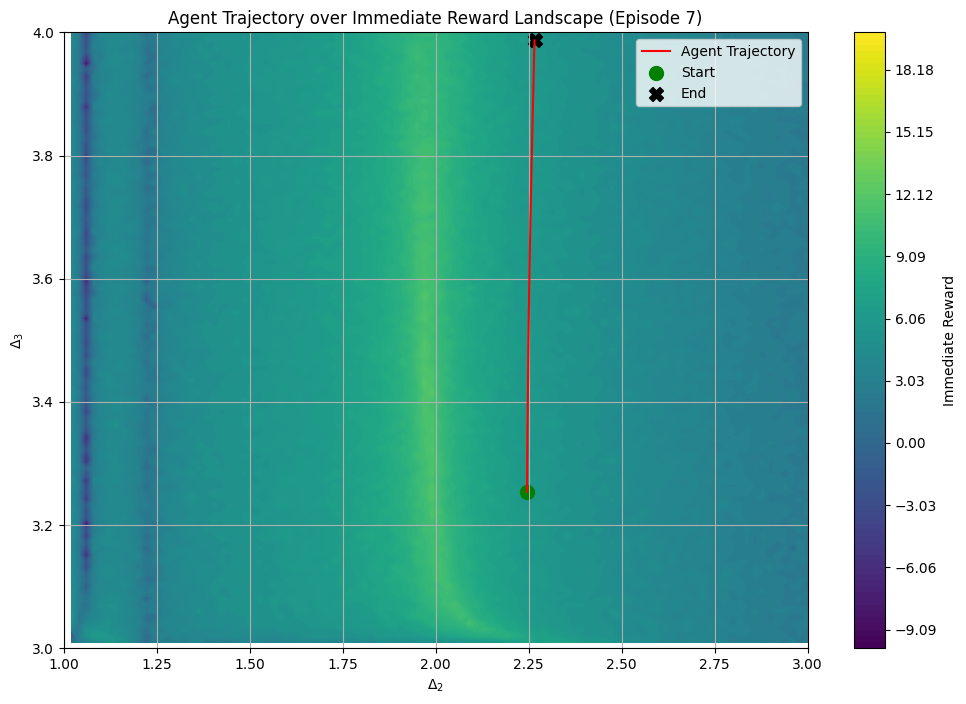

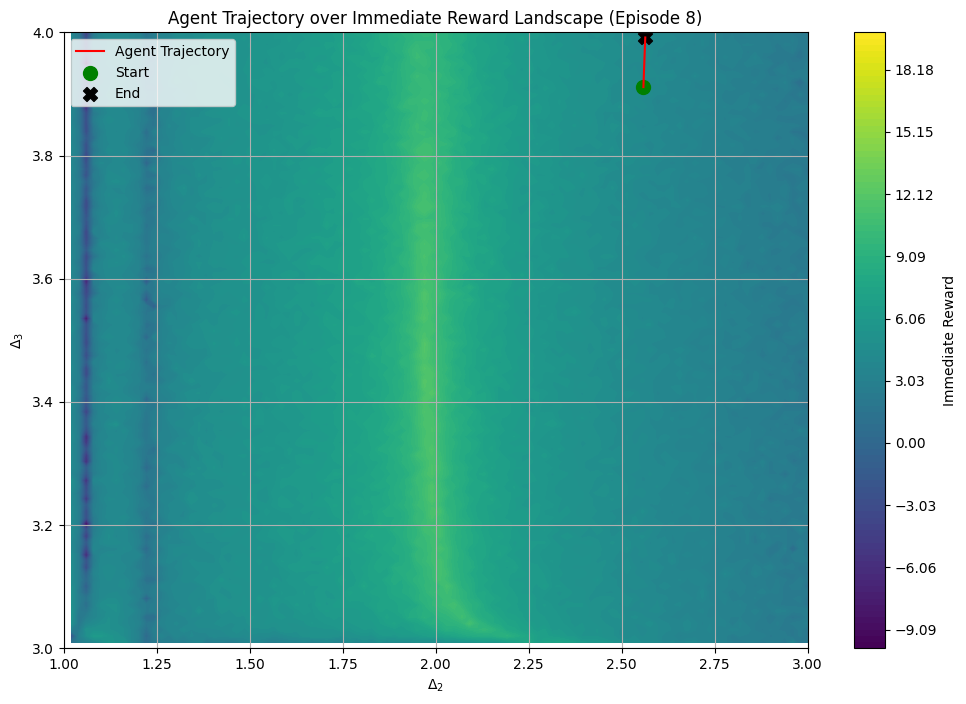

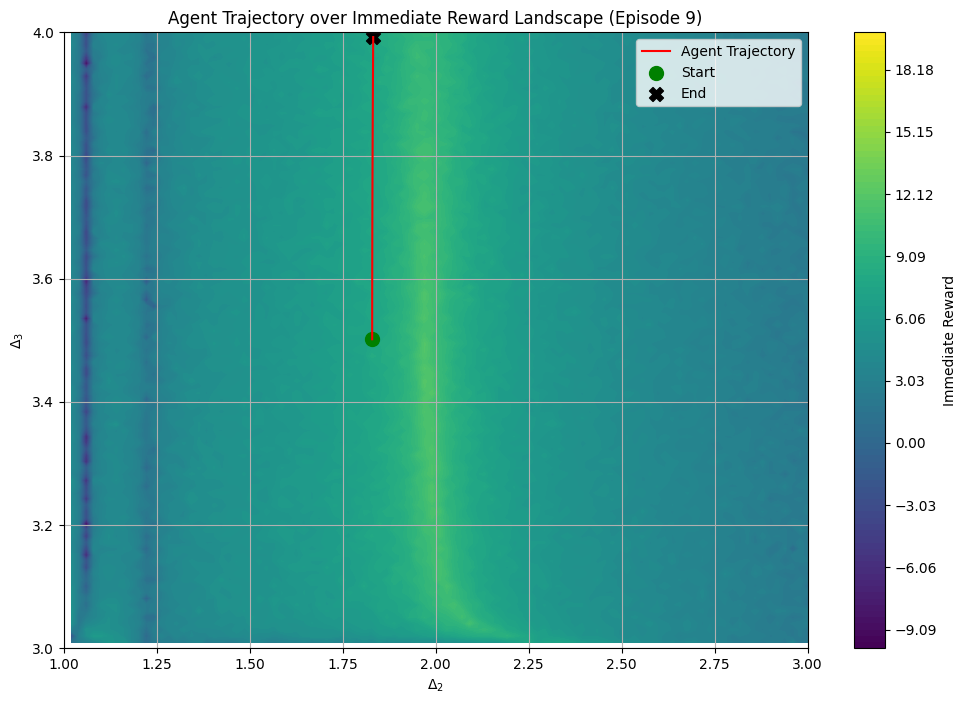

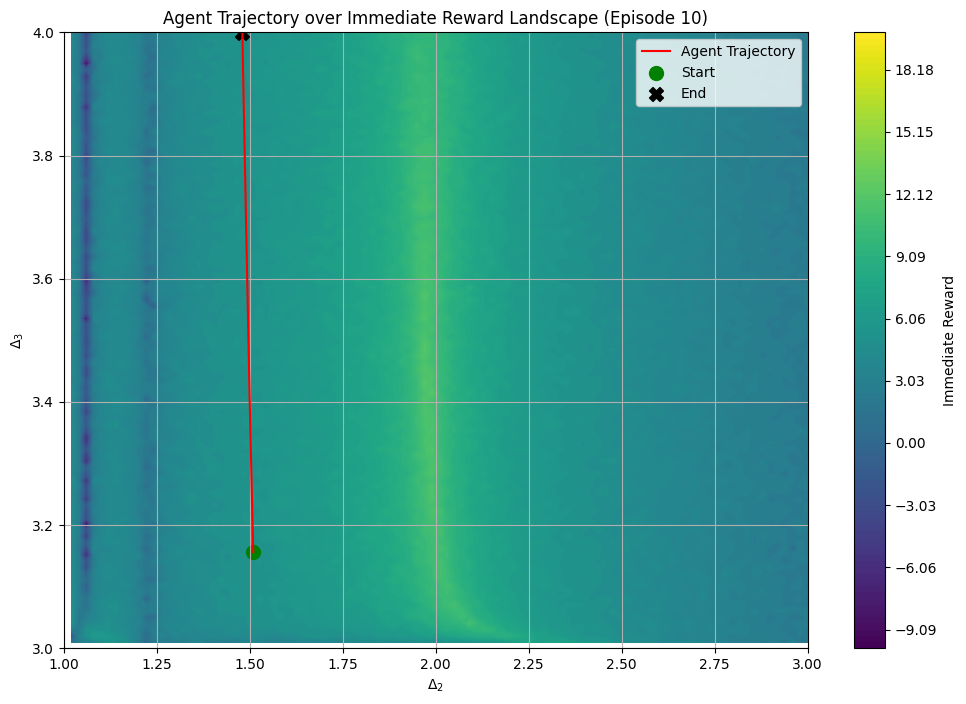

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid parameters
num_points = 100
min_d2 = env.min_d2
max_d2 = env.max_d2
min_d3 = env.min_d3
max_d3 = env.max_d3

# Create the grid
delta2_values = np.linspace(min_d2, max_d2, num_points)
delta3_values = np.linspace(min_d3, max_d3, num_points)
delta2_grid, delta3_grid = np.meshgrid(delta2_values, delta3_values)

# Compute immediate reward over the grid
immediate_reward_grid = np.zeros_like(delta2_grid)
for i in range(delta2_grid.shape[0]):
    for j in range(delta2_grid.shape[1]):
        d2 = delta2_grid[i, j]
        d3 = delta3_grid[i, j]
        immediate_reward_grid[i, j] = env.compute_reward(d2, d3)

# Plotting the trajectory over the reward landscape
for idx, traj in enumerate(trajectories):
    plt.figure(figsize=(12, 8))
    contour = plt.contourf(delta2_grid, delta3_grid, immediate_reward_grid, levels=np.linspace(-10, 20, 100), cmap='viridis')
    plt.colorbar(contour, label='Immediate Reward')
    plt.plot(traj['delta2'], traj['delta3'], linestyle='-', color='red', label='Agent Trajectory')
    
    # Mark the initial point
    plt.scatter(traj['delta2'][0], traj['delta3'][0], color='green', s=100, marker='o', label='Start')
    
    # Mark the final point
    plt.scatter(traj['delta2'][-1], traj['delta3'][-1], color='black', s=100, marker='X', label='End')

    plt.xlabel(r'$\Delta_2$')
    plt.ylabel(r'$\Delta_3$')
    plt.title(f'Agent Trajectory over Immediate Reward Landscape (Episode {idx + 1})')
    plt.legend()
    plt.grid(True)
    plt.show()
